In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

--2025-11-22 22:58:20--  https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4767 (4.7K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.66K  --.-KB/s    in 0s      

2025-11-22 22:58:20 (42.6 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4767/4767]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/1f62

0.3192754284070505
Prior to start time loop. Hallo!
time counter and time:  1 0.3192754284070505
time counter and time:  7048 2250.253219412898
time counter and time:  14095 4500.187163396575
time counter and time:  21142 6750.121107382881
time counter and time:  28189 9000.055051366886
time counter and time:  35237 11250.30827077519
time counter and time:  42284 13500.242214755086
time counter and time:  49331 15750.176158734983
time counter and time:  56378 18000.11010271488
time counter and time:  56378 18000.11010271488
Elapsed time (min): 6.619565765062968


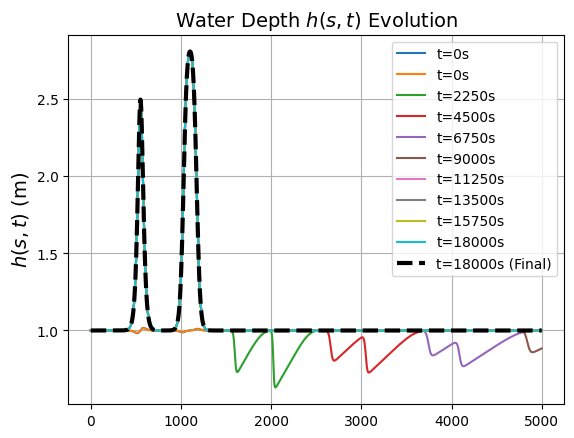

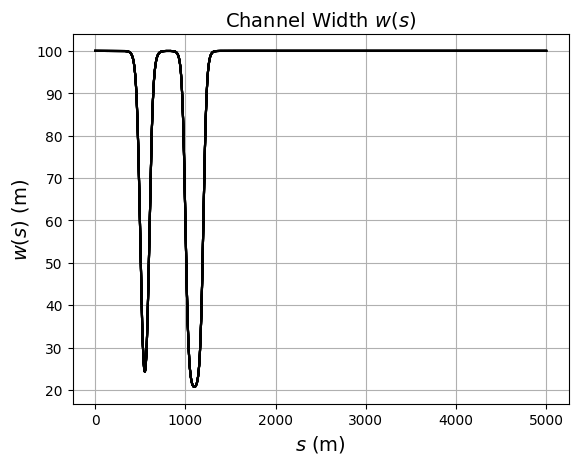

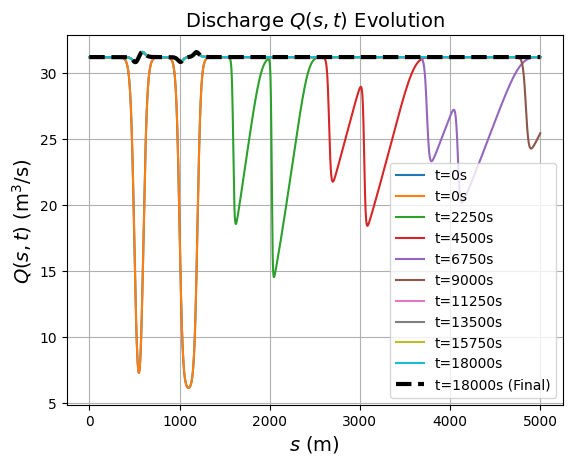

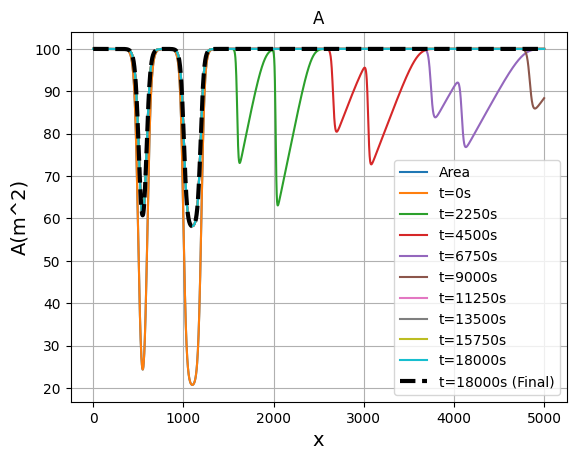

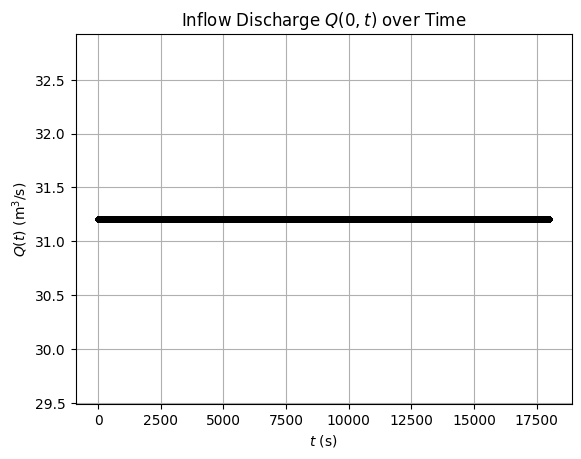

*************** PROGRAM ENDS ******************


In [6]:
#
#
# 1D St-Venant kinematic river flow
# O. Bokhove 02-10-2025
#
# See also: https://www.firedrakeproject.org/demos/DG_advection.py.html which one can (try to) adapt
#
# NOTE: Check TC0 and TC1
#
# TC2: to test and implement
#
#
# from firedrake import *
import firedrake as fd
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
import os.path
from ufl import tanh as ufl_tanh
#import os ONNO 11-02-2023: no idea about opnumthreats warning?
os.environ["OMP_NUM_THREADS"] = "1"



# Width functions
#
def width(w0, w1, sa, sb, kk1, ss):
 return w0-0.5*w1*(tanh(kk1*(ss-sa))*tanh(kk1*(sb-ss)))
#
def width2ufl(w0, w1, w2, sa, sb, kk1, kk2, sc, sd, ss):
 return w0-0.25*w1*(1+ufl_tanh(kk1*(ss-sa)))*(1+ufl_tanh(kk1*(sb-ss)))-0.25*w2*(1+ufl_tanh(kk2*(ss-sc)))*(1+ufl_tanh(kk2*(sd-ss)))
 # return w0-0.5*w1*(ufl_tanh(kk1*(ss-sa))*ufl_tanh(kk1*(sb-ss)))-0.5*w2*(ufl_tanh(kk2*(ss-sc))*ufl_tanh(kk2*(sd-ss)))

#
# Parameters
#
Nbc = 4
if Nbc==4:
    Tend = 3600*5 # UPDATE: set this one
    CFL = 0.5
    Lx = 5000 # UPDATE: vary this one; 5000 may be a bit large bit do a visual converge analysis
    grav = 9.81
    xo = 1000
    xa = 1500-xo
    xb = 1600-xo
    xc = 2000-xo
    xd = 2200-xo
    k1 = 0.024
    k2 = 0.027
    w0 = 100
    w1 = 90
    w2 = 80
    wb = 20
    hb = 4
    nRP = 0 # UPDATE 0: A=w0*h ; 1: Test-Case-2: A<hb*wb A= h*wb ; A>hb*wb: A= A0+Ab=hb*wb+w0*(h-hb) so h-hb=(A-hb*wb)/w0;
    # R = A/(wb+2*hb+(w0-wb)+2*(h-hb)) = A/(wb+2*hb+(w0-wb)+2*(A-hb*wb)/w0)
    #  A<hb*wb then P = wb+2*A/wb ; A>hb*wb then P=(wb+2*hb+(w0-wb)+2*(A-hb*wb)/w0)
    H0 = 1
    slope = -0.001
    sqrtmslope = np.sqrt(-slope)
    Cm = 0.1
    Nx = 2500
    dxx = Lx/Nx
    c00 = np.sqrt(grav*H0)
    dt = CFL*dxx/np.amax(c00) # This should be CFL*dxx/lambdamax
    print(dt)
    nmea = 8
    tmease = 0.0
    dtmeas = Tend/nmea
    Qmax = 350*0  # UPDATE TC0) 0 constant influx TC1/TC2) nonzero varying influx
    tmax = 0.5*Tend
    gamfac = 0.000001
    gamma = 1.0e-5   # s^-2 (as you asked)

nnm = 0  # counter outputs

#
# Mesh
# mesh1d = UnitIntervalMesh(Nx)
mesh1d = fd.IntervalMesh(Nx,Lx)
# 2D mesh: mesh = ExtrudedMesh(mesh1d, layers=Ny)
mesh = mesh1d
#  coords = mesh.coordinates
# 2D mesh and coordinates: coords.dat.data[:,0] = Lx*coords.dat.data[:,0] coords.dat.data = Lx*coords.dat.data
x, = fd.SpatialCoordinate(mesh)

#
# Define function spaces
#
nDG = 0
nCG = 4
DG0 = fd.FunctionSpace(mesh, "DG", nDG) # Finite volume
CG1 = fd.FunctionSpace(mesh, "CG", nCG) # Continuous
A0 = fd.Function(DG0, name="A0") # Previous time step A^n
A01 = fd.Function(DG0, name="A01")
A02 = fd.Function(DG0, name="A02")
FA00 = fd.Function(DG0, name="FA00")
wid0 = fd.Function(CG1, name="wid0")
A1 = fd.Function(DG0, name="A1") # Future time step A^n+1
wid1 = fd.Function(DG0, name="wid1")
A0_trial = fd.TrialFunction(DG0) # Trial/test function; for DG0 unity in cell and zero elsewhere
wid0_trial = fd.TrialFunction(DG0)
A0_test = fd.TestFunction(DG0) # Trial/test function; for DG0 unity in cell and zero elsewhere
wid0_test = fd.TestFunction(DG0)

#
# We define n to be the built-in FacetNormal object;
# a unit normal vector that can be used in integrals over exterior and interior facets.
# We next define un to be an object which is equal to
# if this is positive, and zero if this is negative. This will be useful in the upwind terms.
# how to distinguish interior from exterior facets?
#

# initial condtion and plot it
tijd = 0.0
if Nbc==4: # flow
 wx = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
 A0 = fd.Function(DG0).interpolate(H0*wx+0.0*x)
 wid0 = fd.Function(CG1).interpolate(wx+0.0*x)

t = tijd
t_ = fd.Constant(t)
smallfac = 10.0**(-10.0)
tsize = 14

nx = Nx
xsmall = 0.0*10**(-6)
xvals = np.linspace(0.0+xsmall, Lx-xsmall, nx)
widvals = 0.0*xvals
# --- Setup figures (REVISED) ---
# Figure 1: Water Depth h(s,t)
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)
ax1.set_title(r'Water Depth $h(s,t)$ Evolution',fontsize=tsize)
ax1.set_ylabel(r'$h(s,t)$ (m)',fontsize=tsize)
ax1.grid()

# Figure 2: Channel Width w(s)
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)
ax2.set_title(r'Channel Width $w(s)$',fontsize=tsize)
ax2.set_ylabel(r'$w(s)$ (m)',fontsize=tsize)
ax2.grid()
ax2.set_xlabel(r'$s$ (m)',fontsize=tsize) # Added x-label here

# Figure 3: Discharge Q(s,t)
fig3 = plt.figure(3)
ax3 = fig3.add_subplot(111)
ax3.set_title(r'Discharge $Q(s,t)$ Evolution',fontsize=tsize)
ax3.set_xlabel(r'$s$ (m) ',fontsize=tsize)
ax3.set_ylabel(r'$Q(s,t)$ (m$^3$/s) ',fontsize=tsize)
ax3.grid()
#

fig5=plt.figure(4)
ax5=fig5.add_subplot(111)
ax5.set_title('A')
ax5.set_xlabel('x',fontsize=tsize)
ax5.set_ylabel('A(m^2)',fontsize=tsize)
ax5.grid()


eta12 = np.array([A0.at(x) for x in xvals]) #
phi12 = np.array([wid0.at(x) for x in xvals])
widL = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) #
Q12 = np.array([FA00.at(x) for x in xvals]) #
ax1.plot(xvals,eta12/phi12, label=f't=0s') # h = A/w
ax2.plot(xvals,phi12, '-k', label=r'Channel Width $w(s)$') # w
ax3.plot(xvals,Q12, label=f't=0s') # Q
ax5.plot(xvals,eta12, label=f'Area')

fig1.savefig("sweDG0FV_Depth_t0.png")
fig2.savefig("sweDG0FV_Width.png")
fig3.savefig("sweDG0FV_Discharge_t0.png")
#)
#
#
#
A00left = fd.Constant(H0*w0)
a_massA0 = A0_test*A0_trial*fd.dx # mass matrix for A0
widL = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
A0avg = 0.5*(A0('+') + A0('-'))
n = fd.FacetNormal(mesh) # ; odd normals in 1d one at first face is likely wrong # 1D: n = fd.as_vector([1.0])
#
if nRP==0:
 #
 A0left = fd.Constant(H0*w0) # constant inflow for test case
 A0left0 = H0*w0
 #
elif nRP==1:
 #
 A0left = fd.Constant(H0*wb) # constant inflow for test case
 A0left0 = H0*wb
 #
FA0left = fd.Constant(0.0)
widL0 = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, 0)

if nRP==0:
 #
 FA0 = sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm #
 FA0left.assign( sqrtmslope*A0left0**(5/3)/(widL0+2.0*A0left0/widL0)**(2/3)/Cm ) #
 FA0left0 = sqrtmslope*A0left0**(5/3)/(widL0+2.0*A0left0/widL0)**(2/3)/Cm
 FA0fluxmin = sqrtmslope*A0('-')**(5/3)/(widL+2.0*A0('-')/widL)**(2/3)/Cm #
 FA0fluxplu = sqrtmslope*A0('+')**(5/3)/(widL+2.0*A0('+')/widL)**(2/3)/Cm #
 dFA0dA0 = (1/3)*sqrtmslope*A0avg**(2/3)*( 5*widL+6*A0avg/widL )/(widL+2.0*A0avg/widL)**(5/3)/Cm #
 dFA0dA0bnd = (1/3)*sqrtmslope*A0**(2/3)*( 5*widL+6*A0/widL )/(widL+2.0*A0/widL)**(5/3)/Cm
 #
elif nRP==1:
 #
 FA0 = fd.conditional( A0<wb*hb, sqrtmslope*A0**(5/3)/(wb+2.0*A0/wb)**(2/3)/Cm , \
                      sqrtmslope*A0**(5/3)/(wb+2*hb+widL-wb+2.0*(A0-hb*wb)/widL)**(2/3)/Cm )
 #FA0left.assign( fd.conditional( A0left0<hb*wb, sqrtmslope*A0left0**(5/3)/(wb+2.0*A0left0/wb)**(2/3)/Cm , sqrtmslope*A0left0**(5/3)/(wb+2*hb+widL0-wb+2.0*(A0left0-hb*wb)/widL0)**(2/3)/Cm  ) )
 if A0left0<hb*wb:
  FA0left0 = sqrtmslope*A0left0**(5/3)/(wb+2.0*A0left0/wb)**(2/3)/Cm
  Qbase = float(FA0left0)

 else:
  FA0left0 = sqrtmslope*A0left0**(5/3)/(wb+2*hb+widL0-wb+2.0*(A0left0-hb*wb)/widL0)**(2/3)/Cm
  Qbase = float(FA0left0)


 FA0left.assign( FA0left0 )

 Peromi = fd.conditional( A0('-')<(hb*wb+0*A0('-')), wb+2*A0('-')/wb, wb+2*hb+widL-wb+2*(A0('-')-hb*wb)/widL )
 Peripl = fd.conditional( A0('+')<(hb*wb+0*A0('+')), wb+2*A0('+')/wb, wb+2*hb+widL-wb+2*(A0('+')-hb*wb)/widL )
 FA0fluxmin = sqrtmslope*A0('-')**(5/3)/Peromi**(2/3)/Cm #
 FA0fluxplu = sqrtmslope*A0('+')**(5/3)/Peripl**(2/3)/Cm #
 dFA0dA0 = (sqrtmslope/(3*Cm))*A0avg**(2/3)*fd.conditional(A0avg<hb*wb+0*A0avg, (5*wb+6*A0avg/wb)/(wb+2.0*A0avg/wb)**(5/3) , \
                                                             (5*(wb+2*hb+widL-wb-2*hb*wb/widL)+6*A0avg/widL)/(wb+2*hb+widL-wb+2*(A0avg-hb*wb)/widL)**(5/3) ) #
 dFA0dA0bnd = (sqrtmslope/(3*Cm))*A0**(2/3)*fd.conditional(A0<hb*wb+0*A0, (5*wb+6*A0/wb)/(wb+2.0*A0/wb)**(5/3) , \
                                                             (5*(wb+2*hb+widL-wb-2*hb*wb/widL)+6*A0/widL)/(wb+2*hb+widL-wb+2*(A0-hb*wb)/widL)**(5/3) ) #
 #
# Upwind flux
FA0flux = fd.conditional(dFA0dA0*n[0]('+')>0,FA0fluxplu,FA0fluxmin) # 2D FA0flux = fd.conditional(fd.dot(dFA0dA0,n)>0,FA0fluxplu,FA0fluxmin)
FA0fluxbcl =  fd.conditional((dFA0dA0bnd*n[0])>0,FA0left+0.0*A0,FA0left+0.0*A0)#
FA0fluxbcr =  fd.conditional((dFA0dA0bnd*n[0])>0,FA0,FA0)
# RHS rewritten version with test function of: A^n - dt*(F_k+1/12-F_k-1/2))
A0rhs = A0_test*A0*fd.dx - dt*FA0flux*n[0]('+')*(A0_test('+')-A0_test('-'))*fd.dS # derivative of test function zero for DG0
# Boundary terms if cell near boundary ds(1) or ds(2)
A0rhs = A0rhs - dt*FA0fluxbcl*n[0]*A0_test*fd.ds(1) - dt*FA0fluxbcr*n[0]*A0_test*fd.ds(2) #
A0_problem = fd.LinearVariationalProblem(a_massA0, A0rhs, A1)
#
# Next 4 lines not used
#
A0rhs2 = fd.replace(A0rhs, {A0: A01})
A0rhs3 = fd.replace(A0rhs, {A0: A02})
A01_problem = fd.LinearVariationalProblem(a_massA0, A0rhs2, A1)
A02_problem = fd.LinearVariationalProblem(a_massA0, A0rhs3, A1)

#
params= {"ksp_type": "preonly", "pc_type": "jacobi"}
solv1 = fd.LinearVariationalSolver(A0_problem) # , solver_parameters) # =params)
solv11 = fd.LinearVariationalSolver(A01_problem) # , solver_parameters) # =params)
solv12 = fd.LinearVariationalSolver(A02_problem) # , solver_parameters) # =params)

dt0 = dt
dt = 0.0
t_.assign(t)
solv1.solve()
dt = dt0
Qs=[]
As=[]
print('Prior to start time loop. Hallo!')
nt = 0
tic = time.time()
while t <= Tend:
    t += dt
    nt = nt+1

    t_.assign(t)
    # Variable time step:
    # dFdmax = fd.maximum( (1/3)*sqrtmslope*A0**(2/3)*( 5*widL+6*A0avg/widL )/(widL+2.0*A0/widL)**(5/3)/Cm )
    # dt = CFL*dxx/dFmax
    #
    # Assign inflow:
    Q00 = FA0left0 + Qmax*np.exp(-gamfac*(t-tmax)**2)
   # Qpulse = Qmax * np.exp(-gamma*(t - tmax)**2)
    #Q00 = Qbase + Qpulse
    FA0left.assign(Q00) #

    solv1.solve()
    A0.assign(A1)
    #
    #
    #
    #
    #
    #
    if t>tmease+smallfac:
        # print('t, tmeas:',t, tmease)
        print('time counter and time: ',nt, t)
        tmease = tmease + dtmeas
        nnm = nnm+1
        eta12 = np.array([A0.at(x) for x in xvals]) #
        phi12 = np.array([wid0.at(x) for x in xvals])
        if nRP==0:
          FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) #
        elif nRP==1:
          FA00 = fd.Function(DG0).interpolate( fd.conditional(A0>hb*wb+0*A0, sqrtmslope*A0**(5/3)/(wb*hb+2.0*A0/wb)**(2/3)/Cm , \
                                sqrtmslope*A0**(5/3)/(wb+2*hb+widL-wb+2.0*(A0-hb*wb)/widL)**(2/3)/Cm  ) )
        Q12 = np.array([FA00.at(x) for x in xvals]) #
        Qs.append(Q12)
        As.append(eta12)

        # Plotting intermediate profiles
        ax1.plot(xvals,eta12/phi12, label=f't={t:.0f}s') # h = A/w
        ax2.plot(xvals,phi12,'-k') # w is constant in time, only plotted once
        ax3.plot(xvals,Q12, label=f't={t:.0f}s') # Q
        ax5.plot(xvals,eta12, label=f't={t:.0f}s')

   #if t>tmE+smallfac:
    plt.figure(5) # New figure for Inflow Q(t)
    plt.plot(t,Q00,'.k')

# --- Plot Last profile (REVISED) ---
print('time counter and time: ',nt, t)
eta12 = np.array([A0.at(x) for x in xvals]) # A
phi12 = np.array([wid0.at(x) for x in xvals]) # w
if nRP==0:
  FA00 = fd.Function(DG0).interpolate( sqrtmslope*A0**(5/3)/(widL+2.0*A0/widL)**(2/3)/Cm ) #
elif nRP==1:
  FA00 = fd.Function(DG0).interpolate( fd.conditional(A0>hb*wb+0*A0, sqrtmslope*A0**(5/3)/(wb*hb+2.0*A0/wb)**(2/3)/Cm , \
                                     sqrtmslope*A0**(5/3)/(wb+2*hb+widL-wb+2.0*(A0-hb*wb)/widL)**(2/3)/Cm) )
Q12 = np.array([FA00.at(x) for x in xvals]) # Q

# Final profile plots
ax1.plot(xvals,eta12/phi12,'--k',linewidth=3, label=f't={t:.0f}s (Final)') # h
ax3.plot(xvals,Q12,'--k',linewidth=3, label=f't={t:.0f}s (Final)') # Q
ax5.plot(xvals,eta12,'--k',linewidth=3, label=f't={t:.0f}s (Final)')
# Note: w(s) (ax2) is time-independent and only needs one plot.

toc = time.time() - tic
print('Elapsed time (min):', toc/60)

# --- Save and show all figures (REVISED) ---
ax1.legend()
ax3.legend()
ax5.legend()

fig1.savefig("sweDG0FV_Depth_fin.png",format="png",dpi=1000,bbox_inches="tight")
fig3.savefig("sweDG0FV_Discharge_fin.png",format="png",dpi=1000,bbox_inches="tight")
fig5.savefig("sweDG0FV_Area_fin.png",format="png",dpi=1000,bbox_inches="tight")

plt.figure(5)
plt.title('Inflow Discharge $Q(0,t)$ over Time')
plt.xlabel('$t$ (s)')
plt.ylabel('$Q(t)$ (m$^3$/s)')
plt.grid()
plt.savefig("sweDG0FVEt.png")

plt.show()
print('*************** PROGRAM ENDS ******************')

In [7]:
data_dict={"x":xvals,
           "Q":Qs[-1]
}
datadict2={"x":xvals,
           "A":As[-1]
}

In [8]:
np.savez("/content/drive/MyDrive/Convergence_data/TC0/QNx2500CFL0125", **data_dict)
np.savez("/content/drive/MyDrive/Convergence_data/TC0/ANx2500CFL0125", **data_dict)
